## Notebook Ini melakukan Regression pada Kompensasi Jasa Pelayanan (Rp)	

### Import Library

In [1]:
%matplotlib inline
from warnings import simplefilter
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,mean_absolute_percentage_error
import shap
shap.initjs()

In [2]:
def eval(evaluation,y_true,y_train_pred,name):
  a_dict = {}
  a_dict['MAE'] = mean_absolute_error(y_true,y_train_pred)
  a_dict['MSE'] = mean_squared_error(y_true,y_train_pred)
  a_dict['MAPE']= round(mean_absolute_percentage_error(y_true,y_train_pred),6)
  a_dict['R squared'] = r2_score(y_true,y_train_pred)
  a_dict['RMSE'] = np.sqrt(mean_squared_error(y_true,y_train_pred))
  evaluation[name] = a_dict

### Read Dataset

In [3]:
data_sampah = pd.read_csv("Data/data_sampah.csv")

In [4]:
data_sampah.head()

,No,Bulan,Tonase (Ton),Ritasi (Rit),Kompensasi Jasa Pelayanan (Rp),Kompensasi Dampak Negatif (Rp),Tahun
0,1,Januari,28695.810,6901,1384246500,307911975,2017
1,2,Februari,25235.730,6065,1215454500,270323175,2017
2,3,Maret,27581.190,6653,1325941500,295281225,2017
3,4,April,29664.735,6264,1430830450,305629567,2017
4,5,Mei,34637.092,6761,1670736200,348815430,2017


In [5]:
data_sampah = data_sampah.drop('Bulan', axis=1)
data_sampah = data_sampah.rename(columns={'No': 'Bulan'})
data_sampah['Series'] = np.arange(1,len(data_sampah.index)+1)

# Mengganti urutan kolom
data_sampah = data_sampah[['Series', 'Bulan','Tahun','Tonase (Ton)', 
                           'Kompensasi Jasa Pelayanan (Rp)',
                           'Kompensasi Dampak Negatif (Rp)']]
data_sampah['Date'] = pd.to_datetime(data_sampah.assign(day=1, month=data_sampah['Bulan'], year=data_sampah['Tahun'])[['year', 'month', 'day']])
data_sampah.set_index('Date', inplace=True)
data_sampah.head()

,Series,Bulan,Tahun,Tonase (Ton),Kompensasi Jasa Pelayanan (Rp),Kompensasi Dampak Negatif (Rp)
Date,,,,,,
2017-01-01,1,1,2017,28695.810,1384246500,307911975
2017-02-01,2,2,2017,25235.730,1215454500,270323175
2017-03-01,3,3,2017,27581.190,1325941500,295281225
2017-04-01,4,4,2017,29664.735,1430830450,305629567
2017-05-01,5,5,2017,34637.092,1670736200,348815430


### Correlation Pada Feature Kompensasi Jasa Pelayanan (Rp)

In [6]:
data_sampah.corr(method='pearson', numeric_only=True).sort_values('Kompensasi Jasa Pelayanan (Rp)', ascending=False)['Kompensasi Jasa Pelayanan (Rp)']

Kompensasi Jasa Pelayanan (Rp)    1.000000
Tonase (Ton)                      0.998625
Kompensasi Dampak Negatif (Rp)    0.753890
Series                            0.532691
Tahun                             0.482177
Bulan                             0.301960
Name: Kompensasi Jasa Pelayanan (Rp), dtype: float64

Karena semua feature memiliki relasi positive pada Kompensasi Jasa Pelayanan maka semua feature tersebut akan digunakan untuk melakukan prediksi nilai dari Kompensasi Jasa Pelayanan

### Split dataset to train and test datasets
    df_train merupakan data sampah dari 2017-2020
    df_test merupakan data sampah dari 2021

In [7]:
df_train = data_sampah.iloc[:48,:]
df_test = data_sampah.iloc[48:,:]

In [8]:
X_train = df_train.loc[:, df_train.columns != 'Kompensasi Jasa Pelayanan (Rp)'] # features
Y_train = df_train.loc[:, 'Kompensasi Jasa Pelayanan (Rp)'] # target
X_test = df_test.loc[:, df_test.columns != 'Kompensasi Jasa Pelayanan (Rp)'] # features
Y_test = df_test.loc[:, 'Kompensasi Jasa Pelayanan (Rp)'] # target

In [9]:
evaluation_train = {}
evaluation_test = {}

### Model Multiple Linear Regression

In [10]:
mlp = LinearRegression()
mlp.fit(X_train,Y_train)

print('Coefficients: ', mlp.coef_)
print ('Intercept: ',mlp.intercept_)

accuracy = mlp.score(X_train,Y_train)
print("Model Accuracy: ", accuracy)

Coefficients:  [-3.97385187e+04 -2.74865118e+05  1.95938833e+04  5.34299804e+04
  3.48864081e-02]
Intercept:  -189356243.54933357
Model Accuracy:  0.9975408408148948


Predicting on Train Data

In [11]:
Kompensasi_Jasa_train = pd.Series(mlp.predict(X_train), index=X_train.index)

eval(evaluation_train,Y_train,Kompensasi_Jasa_train ,'Train MLR')

Predicting on Test Data

In [12]:
Kompensasi_Jasa_pred = pd.Series(mlp.predict(X_test), index=X_test.index)

eval(evaluation_test,Y_test,Kompensasi_Jasa_pred,'Test MLR')

## Random Forest

In [13]:
# Train the model
rf = RandomForestRegressor(n_estimators = 1000, random_state=42)
rf.fit(X_train,Y_train)

accuracy = rf.score(X_train,Y_train)
print("Model Accuracy: ", accuracy)

Model Accuracy:  0.9960177586167622


Predicting on Train Data

In [14]:
Kompensasi_Jasa_train_with_randomforest = pd.Series(rf.predict(X_train), index=X_train.index)

eval(evaluation_train,Y_train,Kompensasi_Jasa_train_with_randomforest,'Train RF')

Predicting on Test Data

In [15]:
Kompensasi_Jasa_pred_with_randomforest = pd.Series(rf.predict(X_test), index=X_test.index)

eval(evaluation_test,Y_test,Kompensasi_Jasa_pred_with_randomforest,'Test RF')

## XGBoost 

In [16]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)
xgb.fit(X_train, Y_train)

accuracy = xgb.score(X_train,Y_train)
print("Model Accuracy: ", accuracy)

Model Accuracy:  0.9996878564737857


Predicting on Train Data

In [17]:
Kompensasi_Jasa_train_with_xgb = pd.Series(xgb.predict(X_train), index=X_train.index)

eval(evaluation_train,Y_train,Kompensasi_Jasa_train_with_xgb,'Train XGBoost')

Predicting on Test Data

In [18]:
Kompensasi_Jasa_pred_with_xgb = pd.Series(xgb.predict(X_test), index=X_test.index)

eval(evaluation_test,Y_test,Kompensasi_Jasa_pred_with_xgb,'Test XGBoost')

### Collection of Visualizations

In [19]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", figsize=(11, 4))
plt.rcParams['lines.linewidth'] = 3  
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


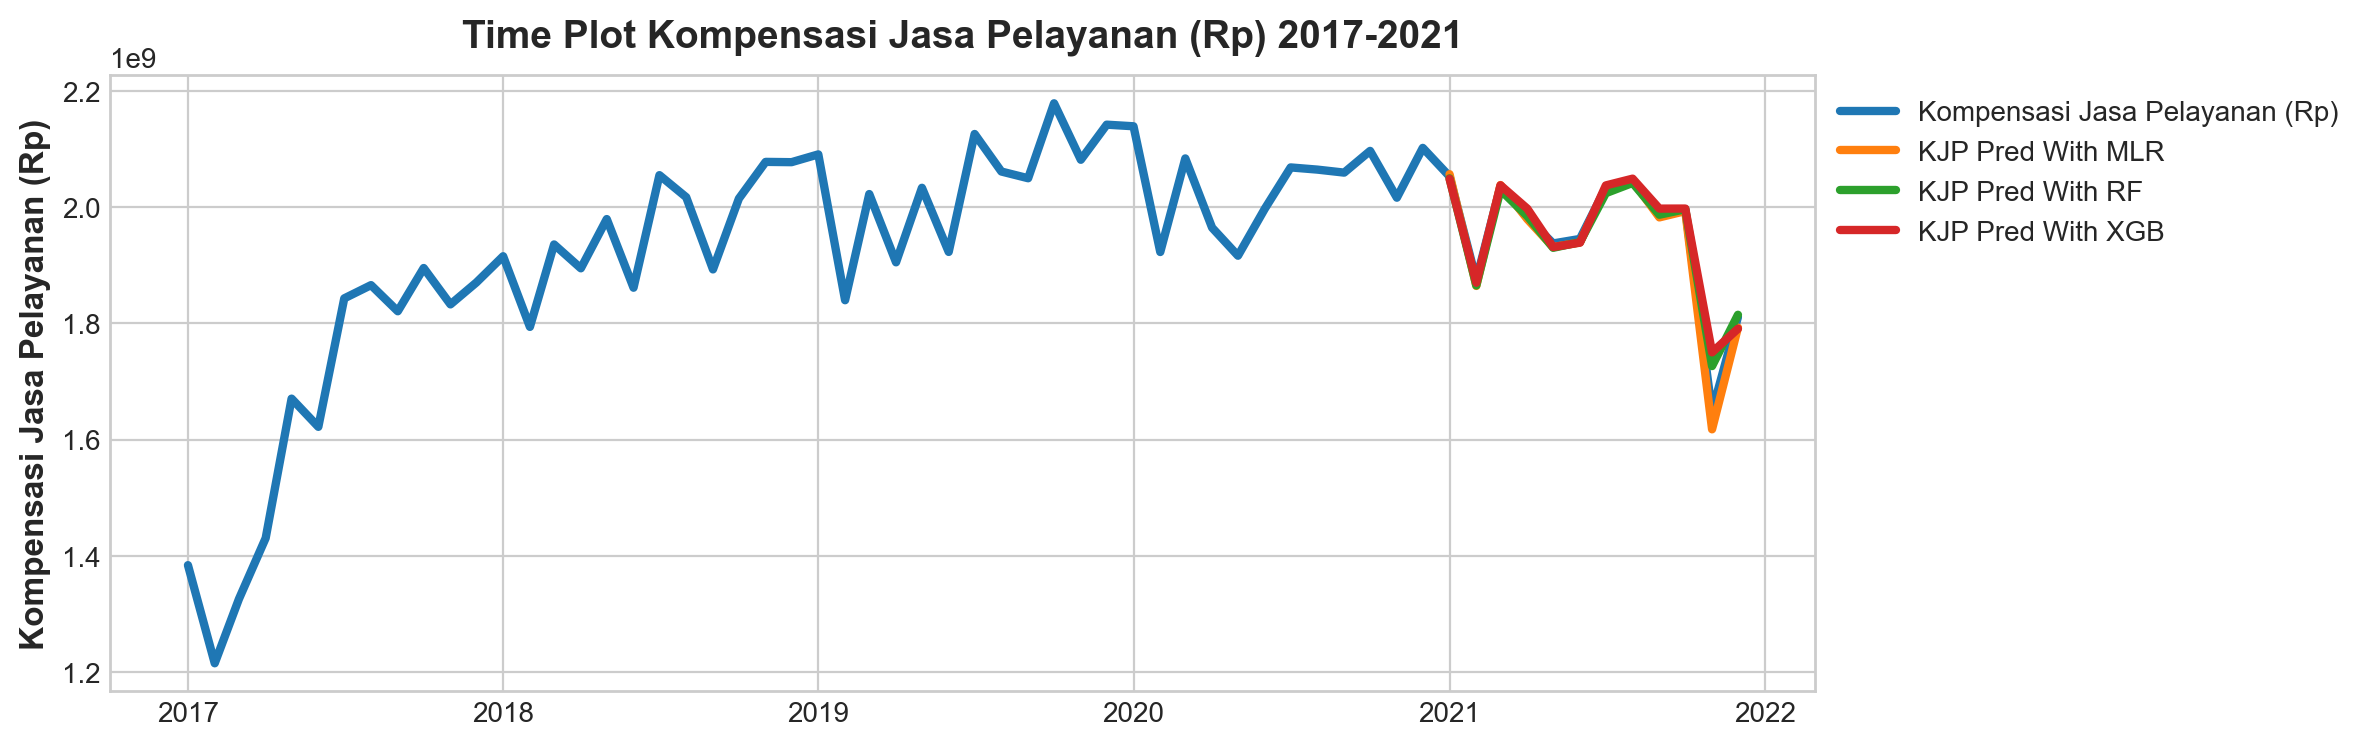

In [20]:
plt.plot(data_sampah['Kompensasi Jasa Pelayanan (Rp)'],label='Kompensasi Jasa Pelayanan (Rp)') 
plt.plot(Kompensasi_Jasa_pred,label='KJP Pred With MLR')
plt.plot(Kompensasi_Jasa_pred_with_randomforest,label='KJP Pred With RF')
plt.plot(Kompensasi_Jasa_pred_with_xgb,label='KJP Pred With XGB')
plt.title('Time Plot Kompensasi Jasa Pelayanan (Rp) 2017-2021')
plt.ylabel("Kompensasi Jasa Pelayanan (Rp)")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()

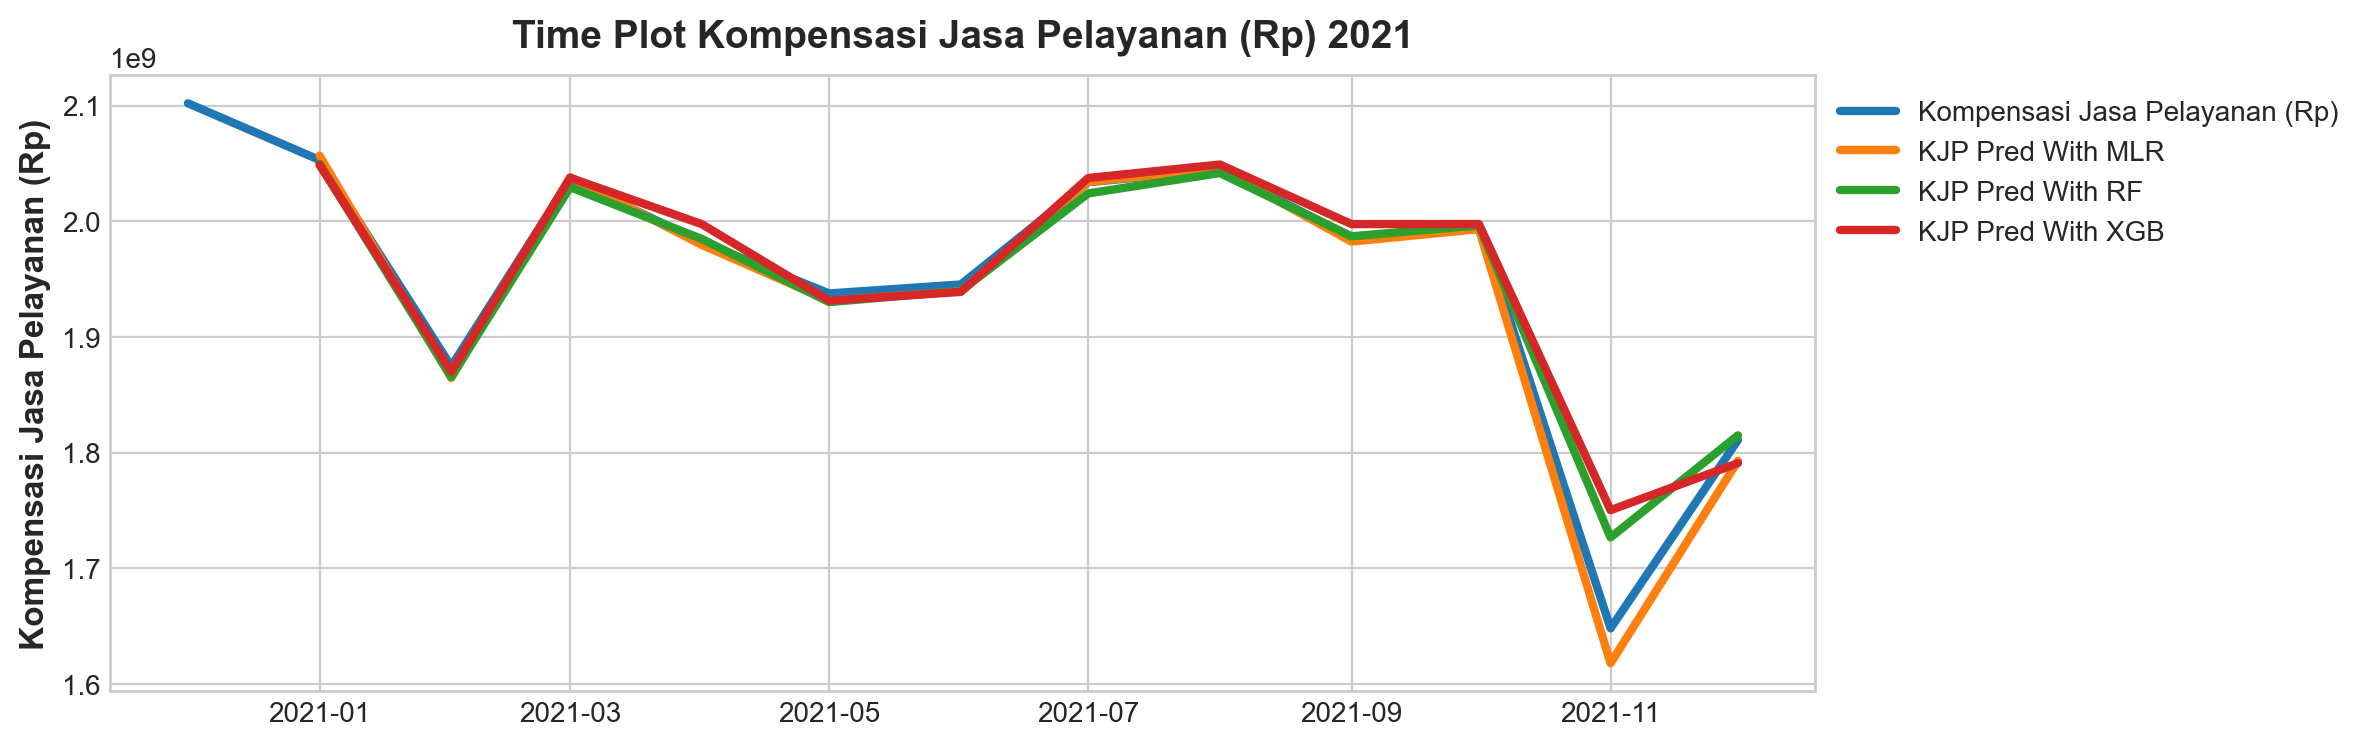

In [21]:
filtered_data = data_sampah[data_sampah.index >= '2020-12-01']
plt.plot(filtered_data['Kompensasi Jasa Pelayanan (Rp)'],label='Kompensasi Jasa Pelayanan (Rp)') 
plt.plot(Kompensasi_Jasa_pred,label='KJP Pred With MLR')
plt.plot(Kompensasi_Jasa_pred_with_randomforest,label='KJP Pred With RF')
plt.plot(Kompensasi_Jasa_pred_with_xgb,label='KJP Pred With XGB')
plt.title('Time Plot Kompensasi Jasa Pelayanan (Rp) 2021')
plt.ylabel("Kompensasi Jasa Pelayanan (Rp)")
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper left')
plt.show()

Mean Absolute Error (MAE) 

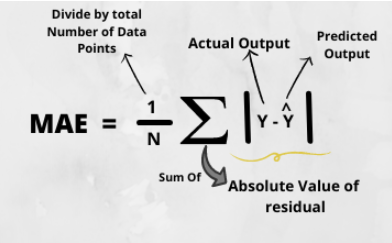

Mean Squared Error(MSE)

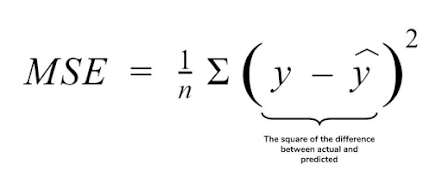

Mean Absolute Percentage Error (MAPE)

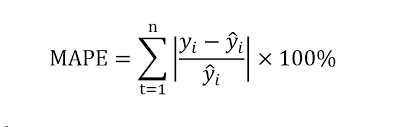

R Squared

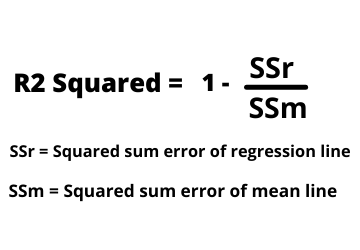

Root Mean Squared Error(RMSE) or root-mean-square deviation (RNSD)

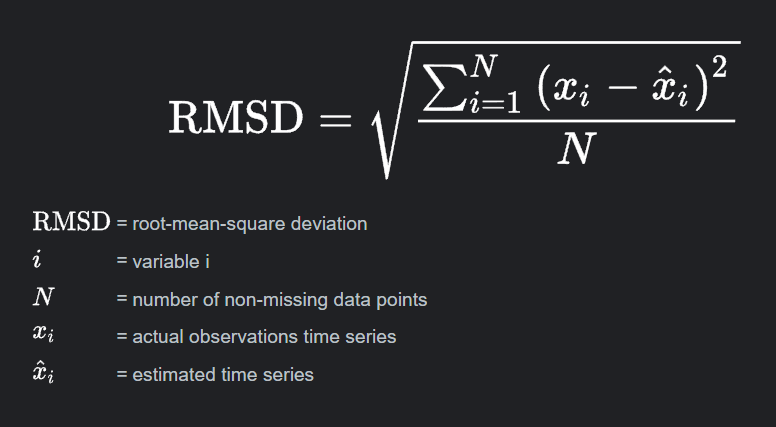


In [22]:
data_eval_train = pd.DataFrame(evaluation_train).T
data_eval_train

,MAE,MSE,MAPE,R squared,RMSE
Train MLR,7.818793e+06,1.110141e+14,0.004342,0.997541,1.053632e+07
Train RF,7.578028e+06,1.797708e+14,0.004544,0.996018,1.340786e+07
Train XGBoost,1.581106e+06,1.409113e+13,0.000809,0.999688,3.753815e+06


In [23]:
data_eval_test = pd.DataFrame(evaluation_test).T
data_eval_test

,MAE,MSE,MAPE,R squared,RMSE
Test MLR,7.274942e+06,1.222642e+14,0.004024,0.990513,1.105731e+07
Test RF,1.088601e+07,5.441411e+14,0.006185,0.957776,2.332683e+07
Test XGBoost,1.510492e+07,9.475330e+14,0.008574,0.926475,3.078202e+07


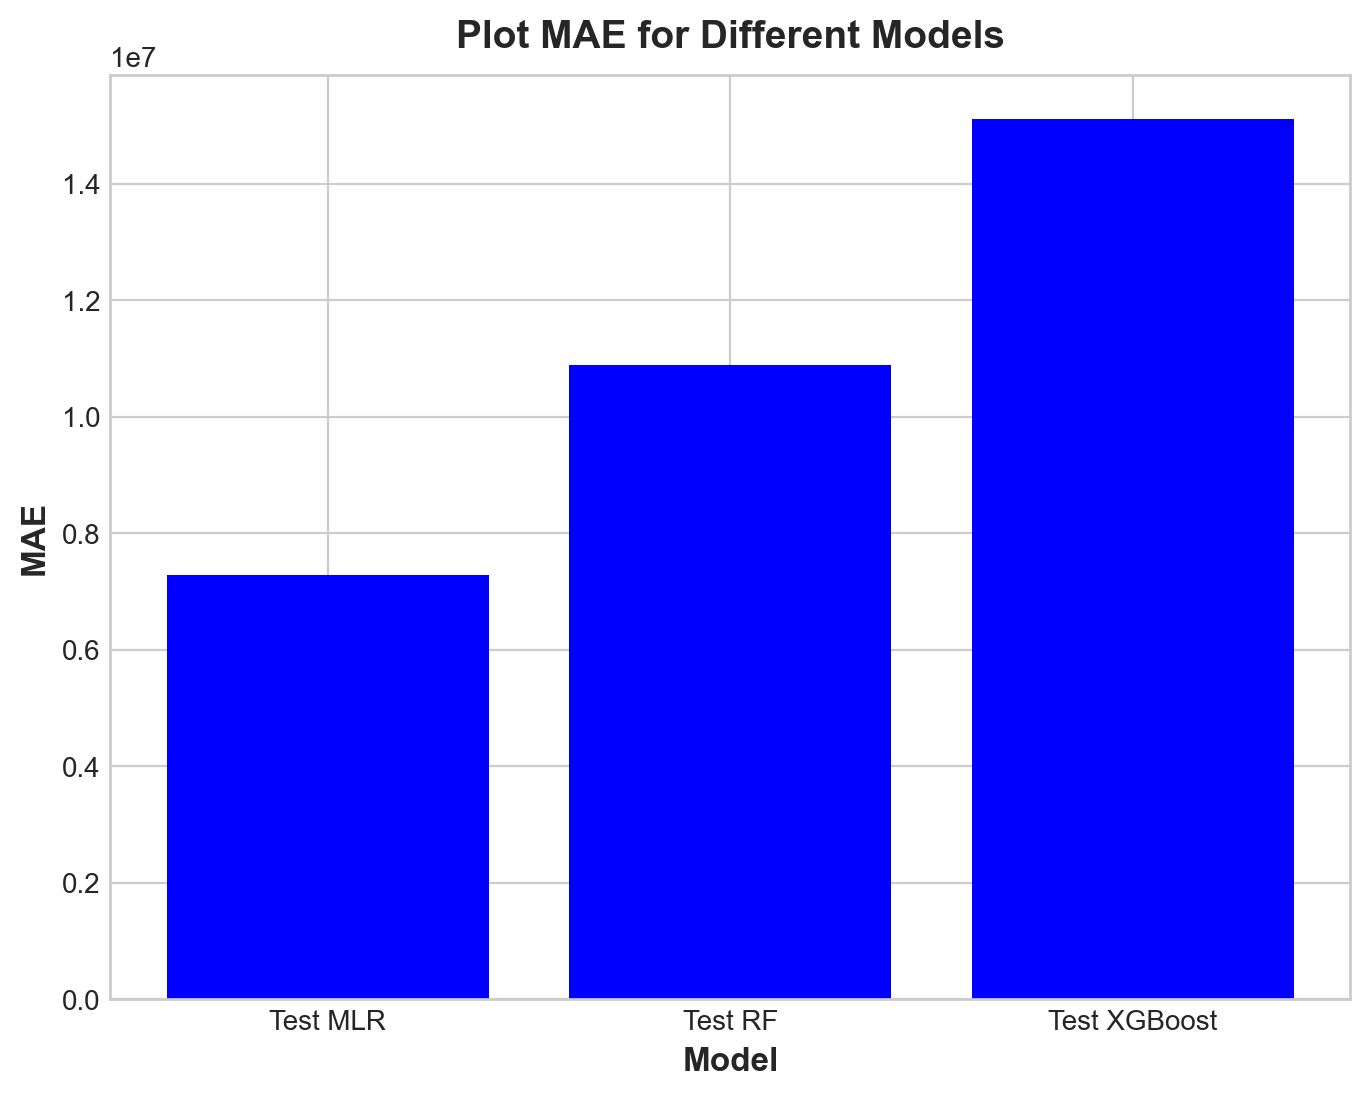

In [24]:
# Plot untuk MAE
plt.figure(figsize=(8, 6))
plt.bar(data_eval_test.index, data_eval_test['MAE'], color='blue')
plt.title('Plot MAE for Different Models')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.show()

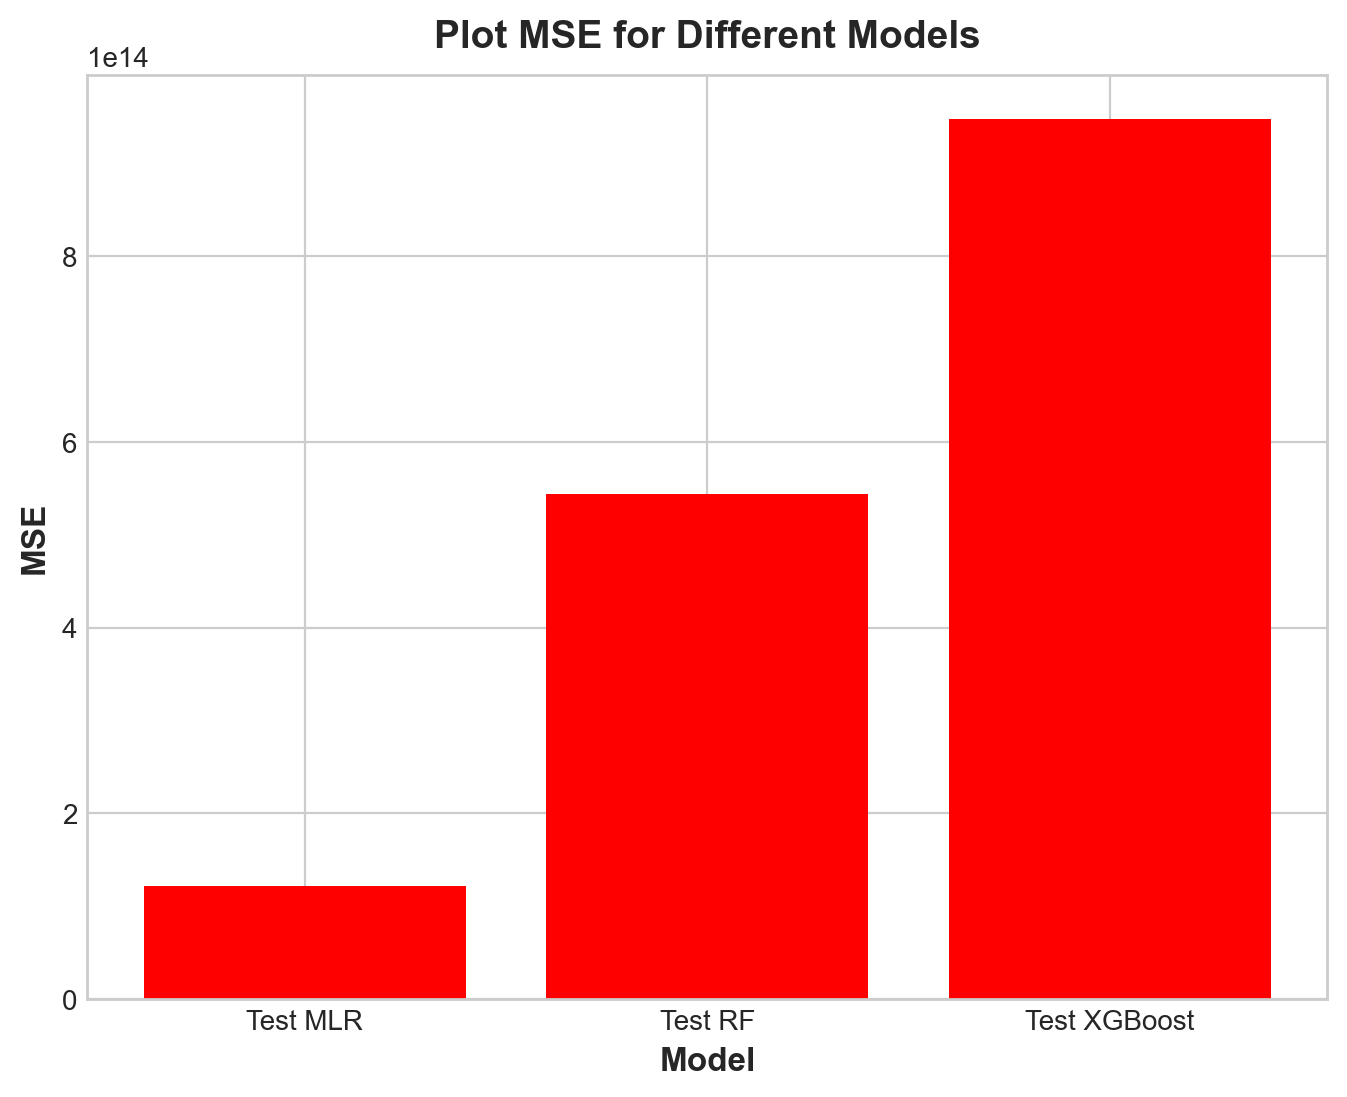

In [25]:
# Plot untuk MSE
plt.figure(figsize=(8, 6))
plt.bar(data_eval_test.index, data_eval_test['MSE'], color='red')
plt.title('Plot MSE for Different Models')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

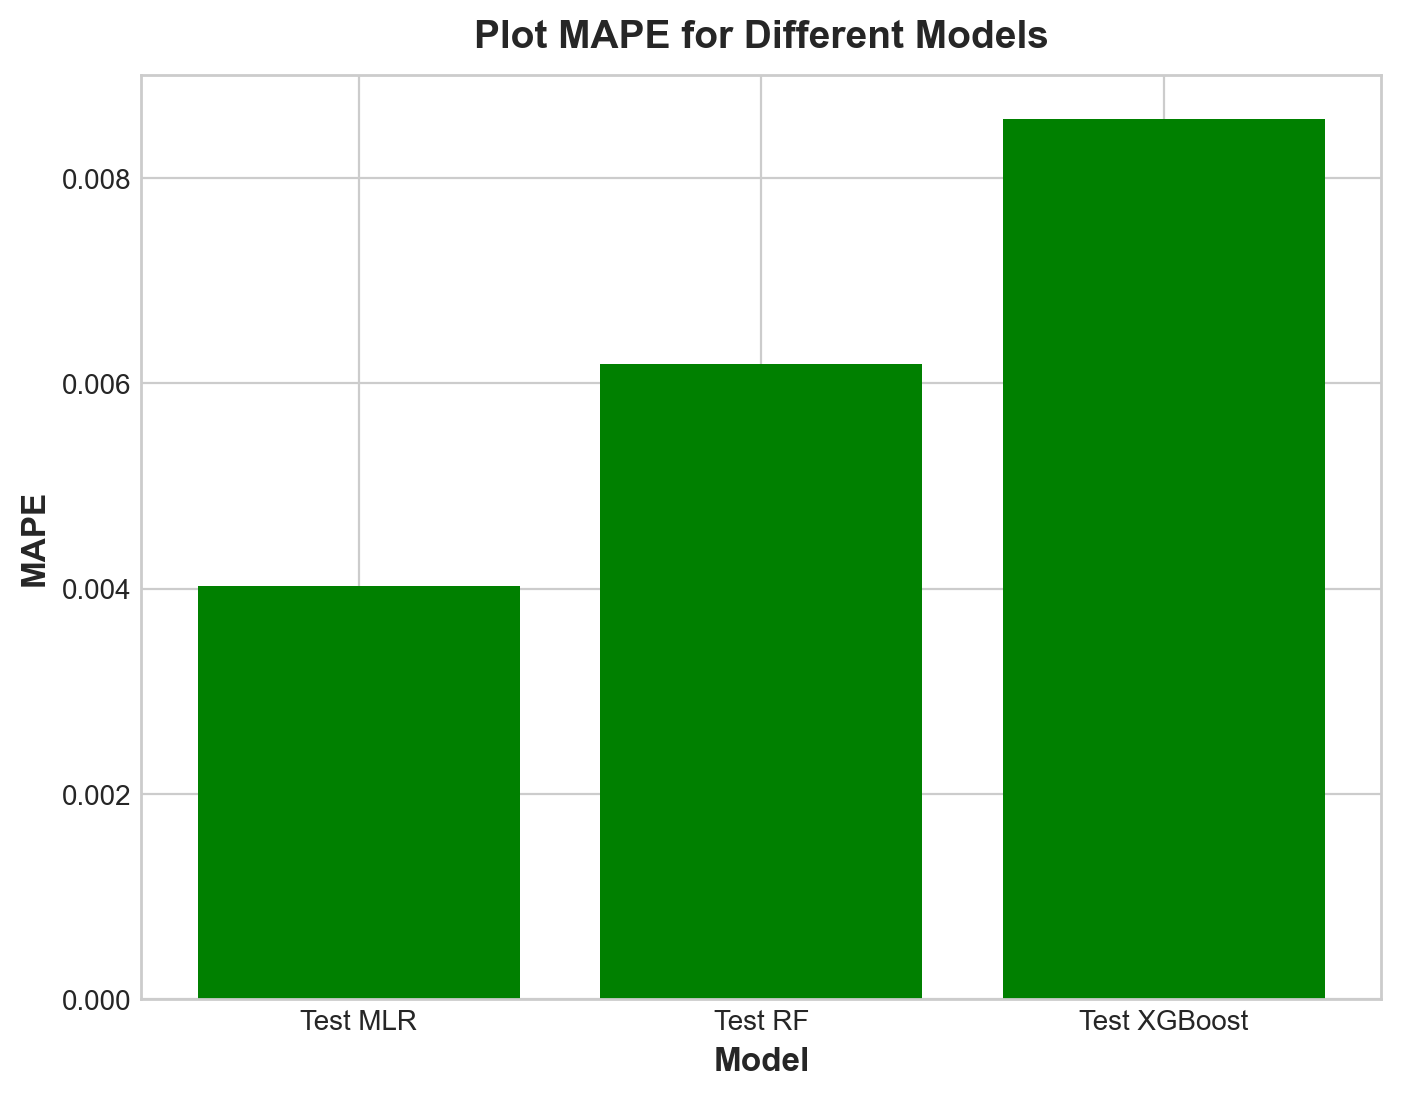

In [26]:
# Plot untuk MAPE
plt.figure(figsize=(8, 6))
plt.bar(data_eval_test.index, data_eval_test['MAPE'], color='green')
plt.title('Plot MAPE for Different Models')
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.show()

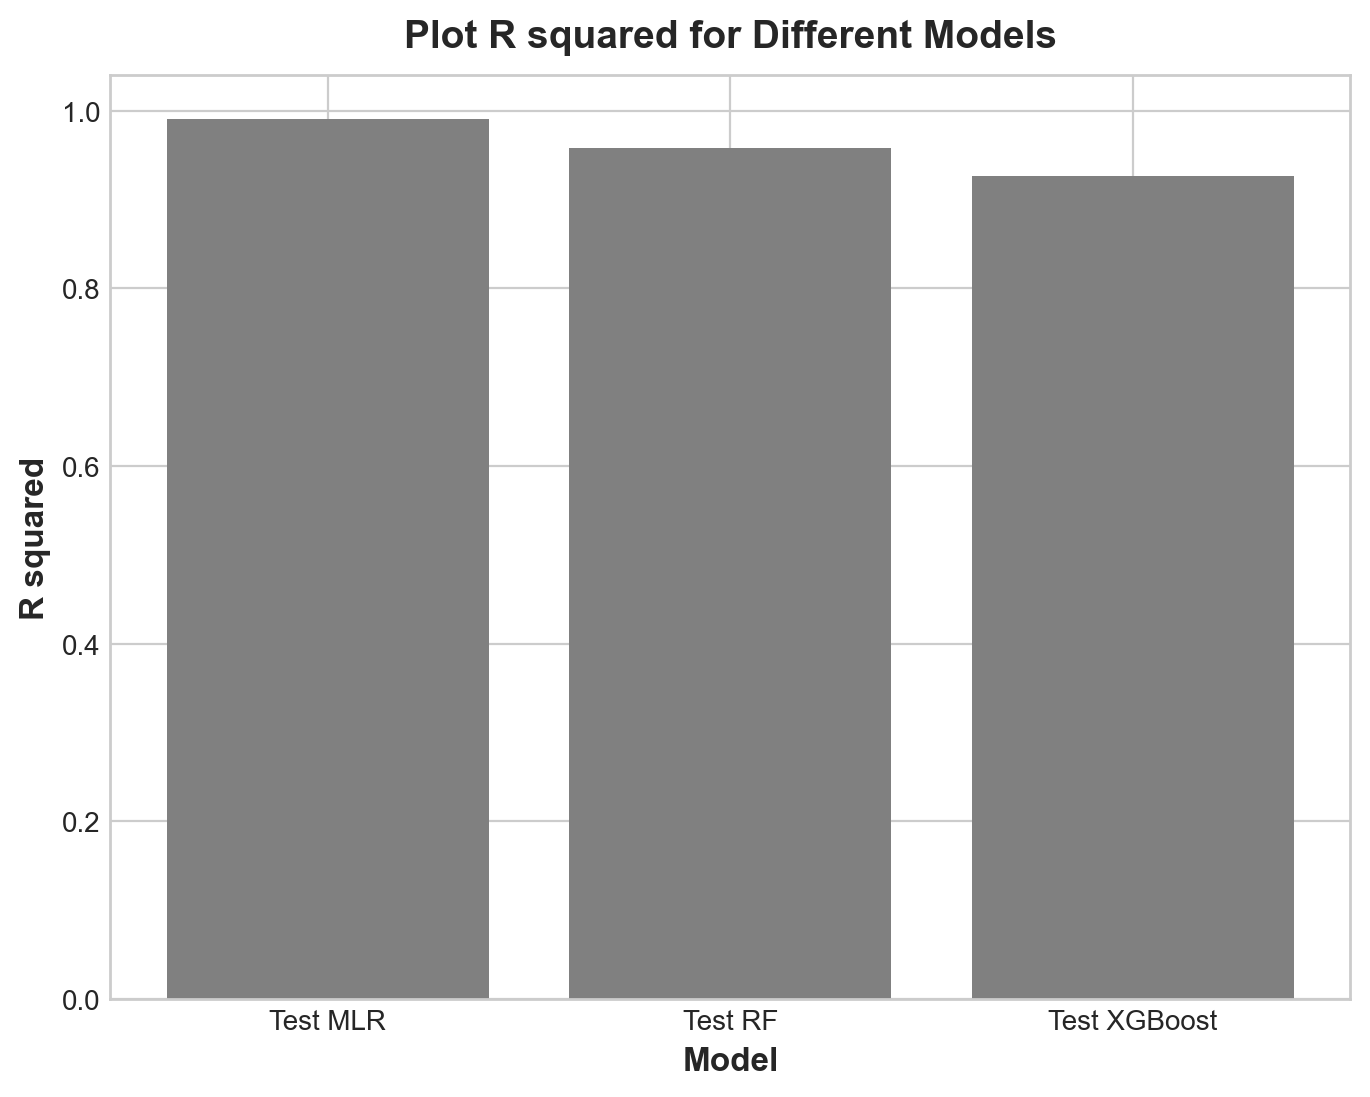

In [27]:
# Plot untuk R squared
plt.figure(figsize=(8, 6))
plt.bar(data_eval_test.index, data_eval_test['R squared'], color='gray')
plt.title('Plot R squared for Different Models')
plt.xlabel('Model')
plt.ylabel('R squared')
plt.show()

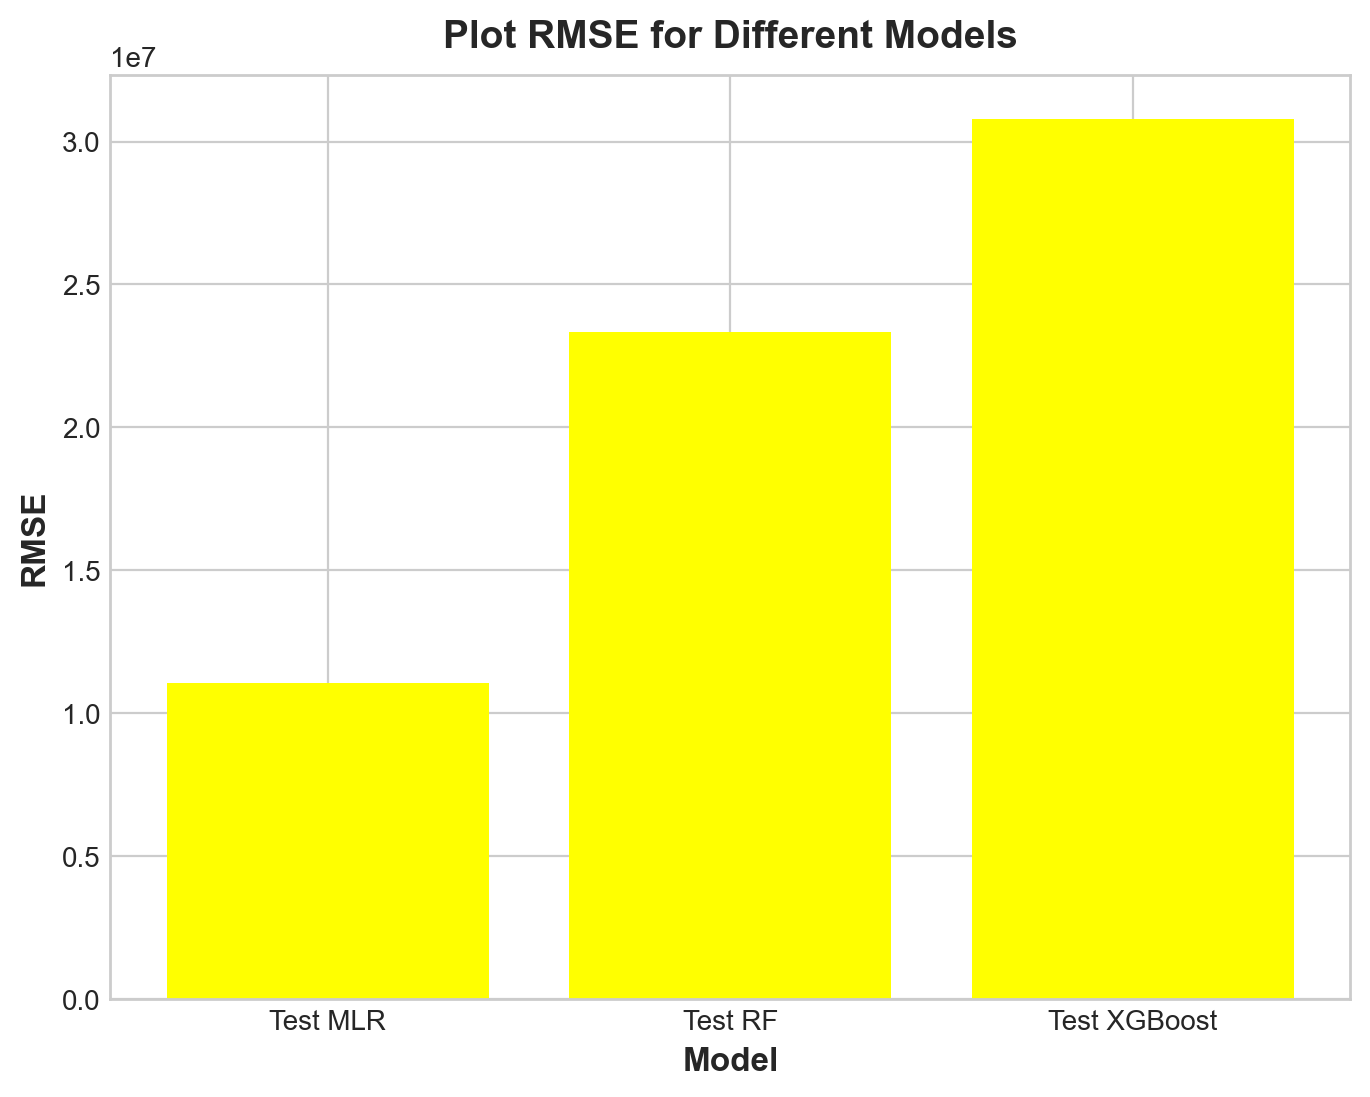

In [28]:
# Plot untuk RMSE
plt.figure(figsize=(8, 6))
plt.bar(data_eval_test.index, data_eval_test['RMSE'], color='yellow')
plt.title('Plot RMSE for Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

### Kesimpulan
Berdasarkan nilai-nilai metrics, model regresi linear berganda atau Multiple Linear Regression (MLR) memiliki kinerja terbaik dengan MAE, MSE, MAPE, R^2, RMSE yang lebih baik daripada model Random Forest dan XGBoost. Dilihat dari data evaluasi prediksinya.

Test MLR:
- MAE: 7.27e+06
- MSE: 1.22e+14
- MAPE: 0.004024
- R^2: 0.990513
- RMSE: 1.11e+07

Notes:

MAE (Mean Absolute Error):
- Semakin kecil nilainya, semakin baik. MAE mengukur rata-rata dari selisih absolut antara prediksi dan nilai sebenarnya. Nilai yang lebih kecil menunjukkan bahwa model memiliki kesalahan prediksi yang lebih rendah.

MSE (Mean Squared Error):
- Semakin kecil nilainya, semakin baik. MSE mengukur rata-rata dari kuadrat dari selisih antara prediksi dan nilai sebenarnya. Seperti MAE, nilai yang lebih kecil menunjukkan bahwa model memiliki kesalahan prediksi yang lebih rendah.

MAPE (Mean Absolute Percentage Error):
- Semakin kecil nilainya, semakin baik. MAPE mengukur persentase rata-rata dari selisih absolut antara prediksi dan nilai sebenarnya. Nilai yang lebih kecil menunjukkan bahwa model memberikan prediksi dalam batas persentase kesalahan yang lebih rendah.

R squared (R^2):
- Semakin besar nilainya, semakin baik. R^2 mengukur seberapa baik variabilitas dalam variabel dependen dapat dijelaskan oleh model. Nilai yang lebih besar, mendekati 1, menunjukkan bahwa model dapat menjelaskan variasi yang lebih besar dalam data.

RMSE (Root Mean Squared Error):
- Semakin kecil nilainya, semakin baik. RMSE adalah akar kuadrat dari MSE dan memberikan bobot lebih pada kesalahan yang besar. Nilai yang lebih kecil menunjukkan bahwa model memiliki kesalahan prediksi yang lebih rendah

### Berikut Penjelasan model MLR dalam memprediksi Kompensasi Jasa Pelayanan (Rp)

Shapley on Training Data

In [29]:
explainer = shap.Explainer(mlp, X_train)
shap_values = explainer(X_train)

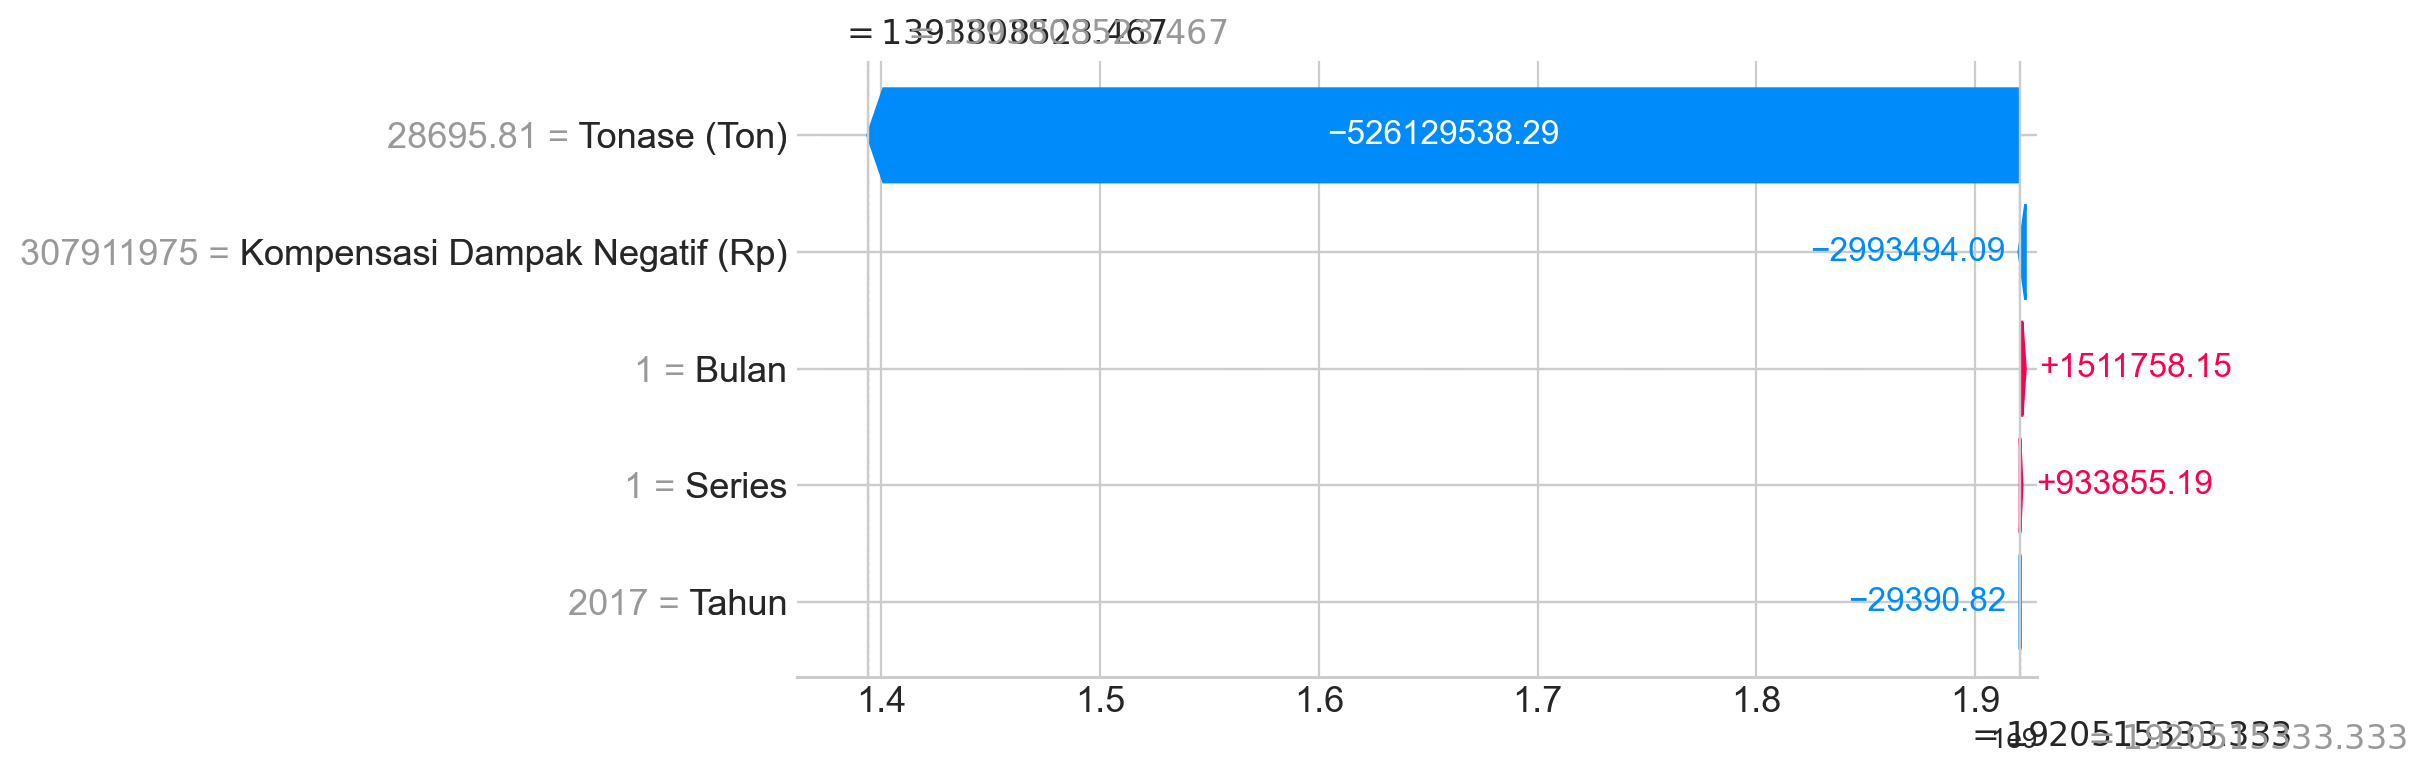

In [30]:
shap.plots.waterfall(shap_values[0])

In [31]:
shap_values = explainer.shap_values(X_train)

In [32]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train,link="logit")

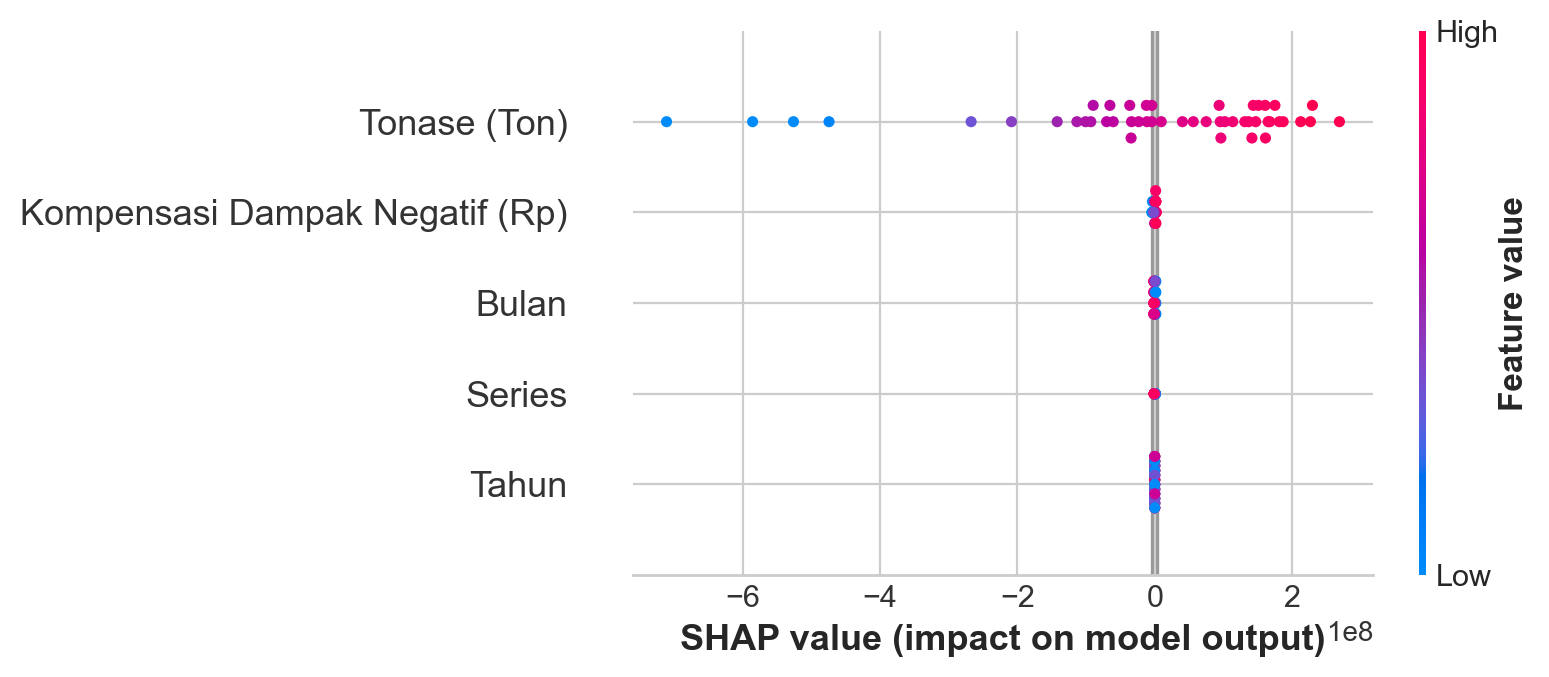

In [33]:
shap.summary_plot(shap_values, X_train)

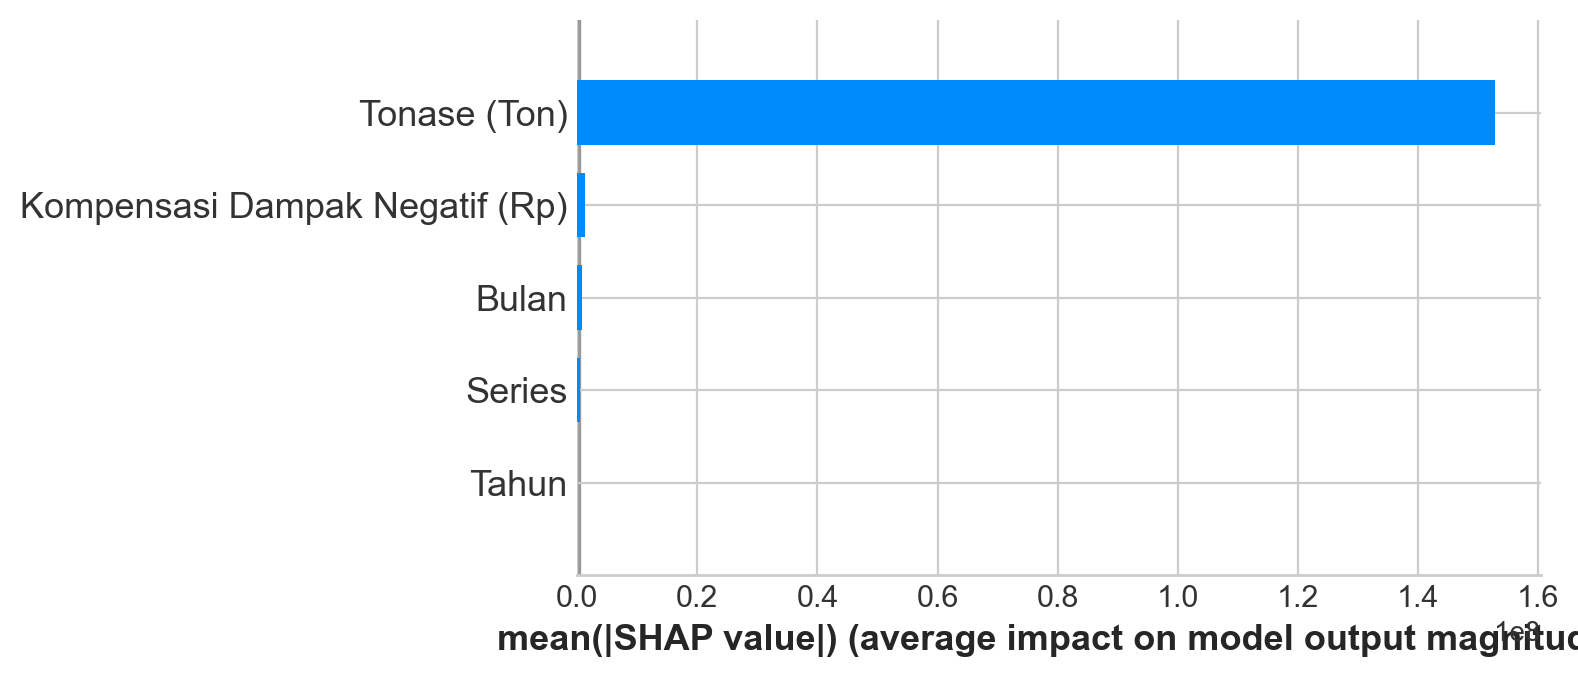

In [34]:
shap.summary_plot(shap_values, X_train, plot_type ="bar")

    Fitur penting yang memiliki nilai rata-rata SHAP terbesar pada metode Regresi Linier Berganda (MLR) pada variabel Kompensasi Jasa Pelayanan (Rp) adalah Tonase (Ton) Sampah yang didapatkan. Semakin tinggi Nilai pada variabel Tonase (Ton) memiliki kontribusi positif yang tinggi terhadap prediksi, sedangkan nilai yang rendah memiliki kontribusi negatif yang tinggi.

Shapley on Test Data

In [35]:
explainer = shap.Explainer(mlp, X_test)
shap_values = explainer(X_test)

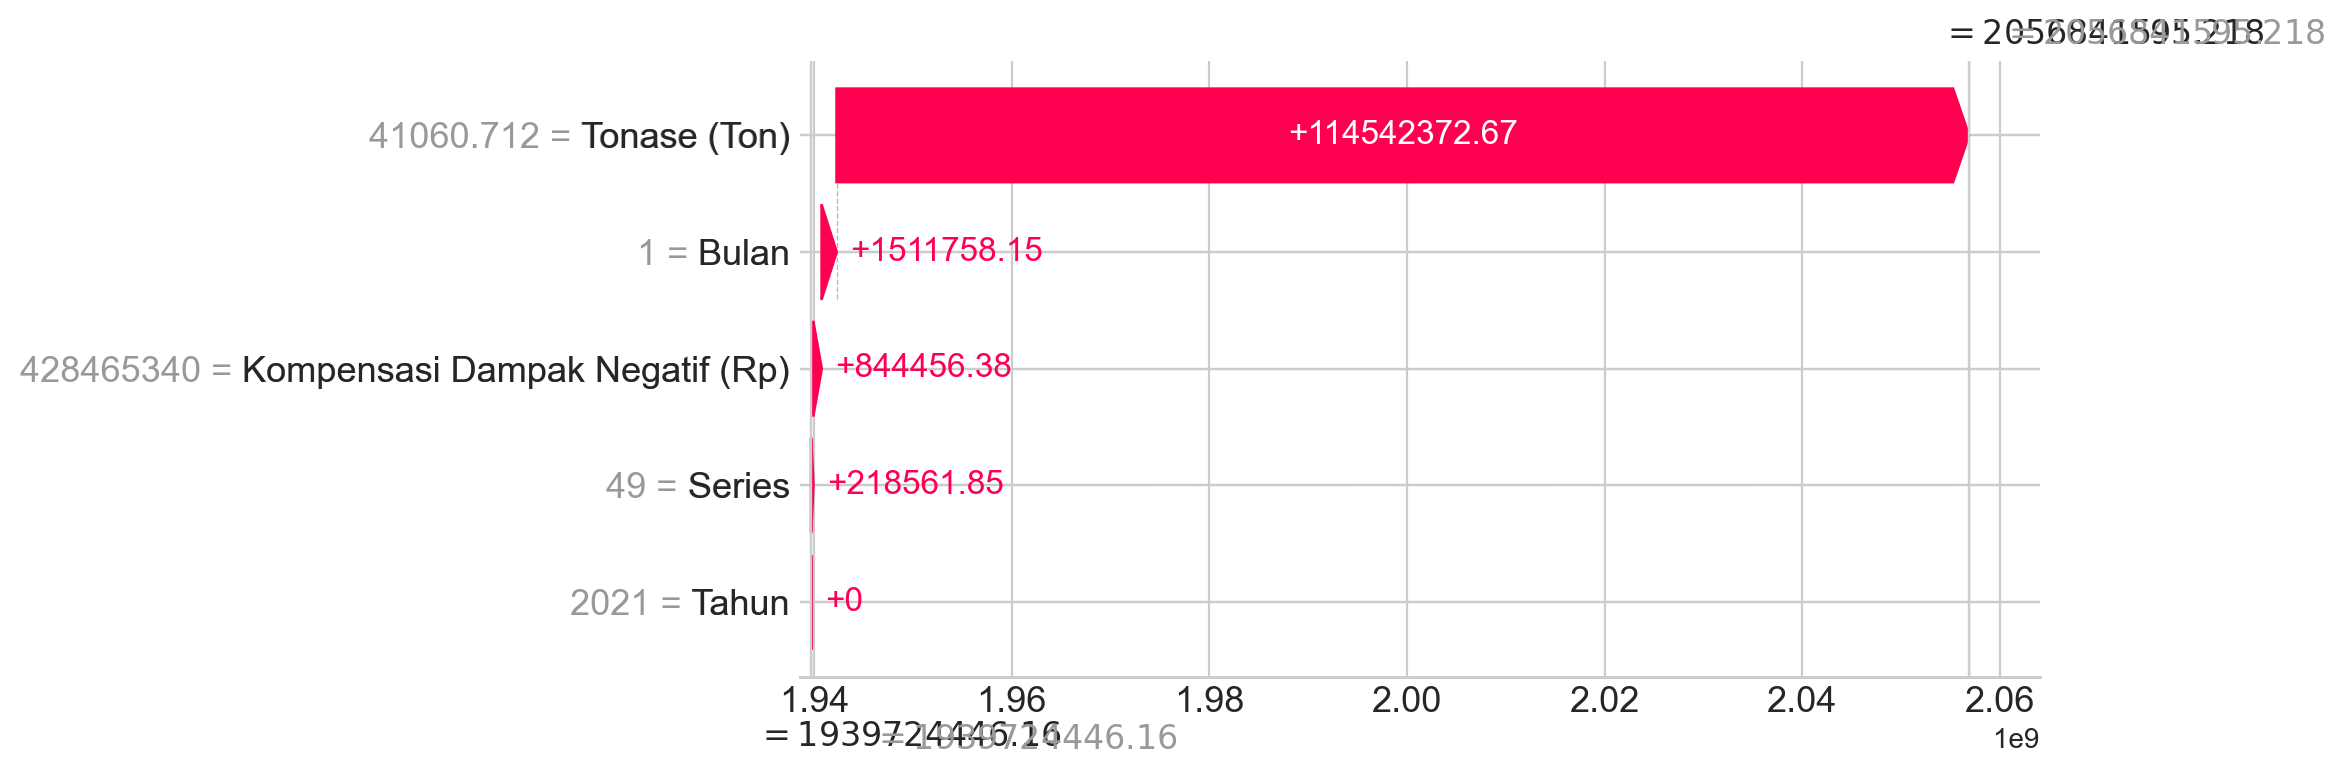

In [36]:
shap.plots.waterfall(shap_values[0])

In [37]:
shap_values = explainer.shap_values(X_test)

In [38]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test,link="logit")

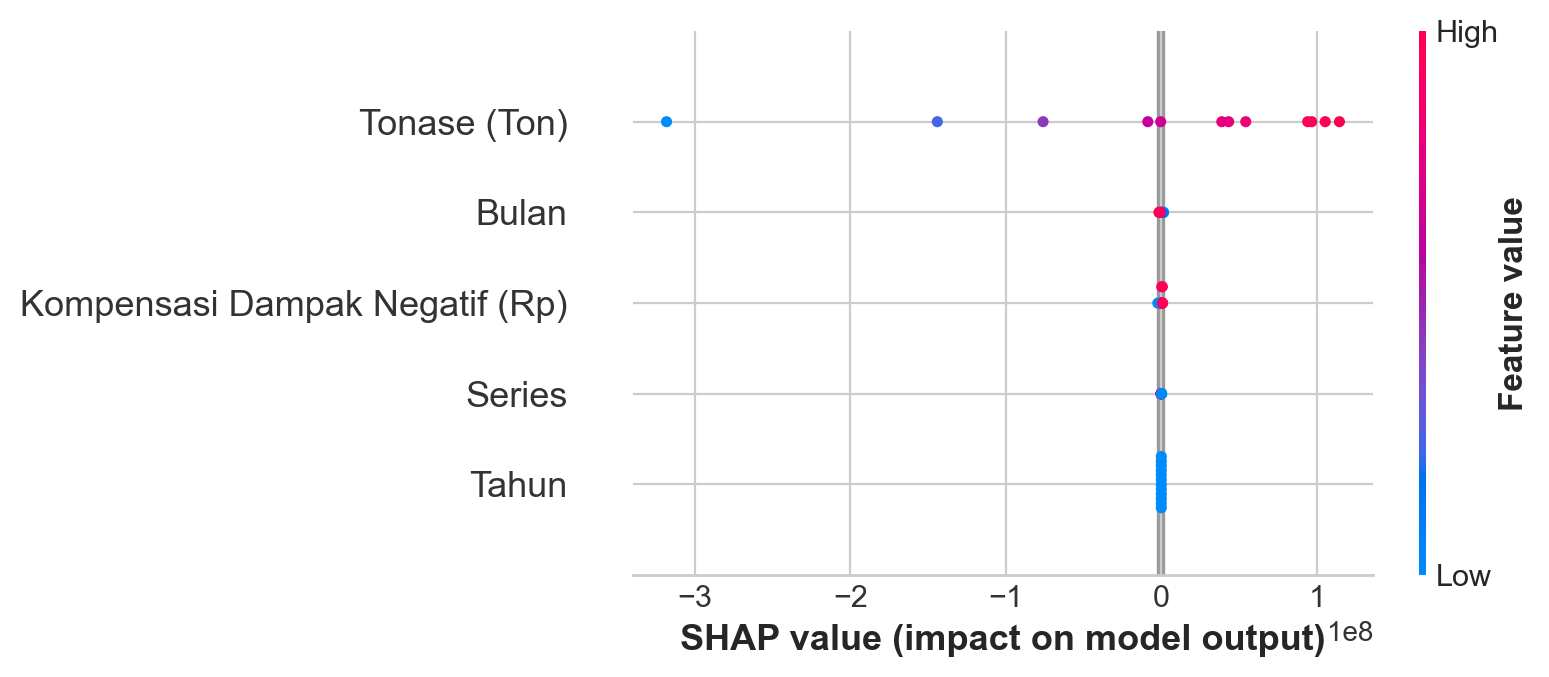

In [39]:
shap.summary_plot(shap_values, X_test)

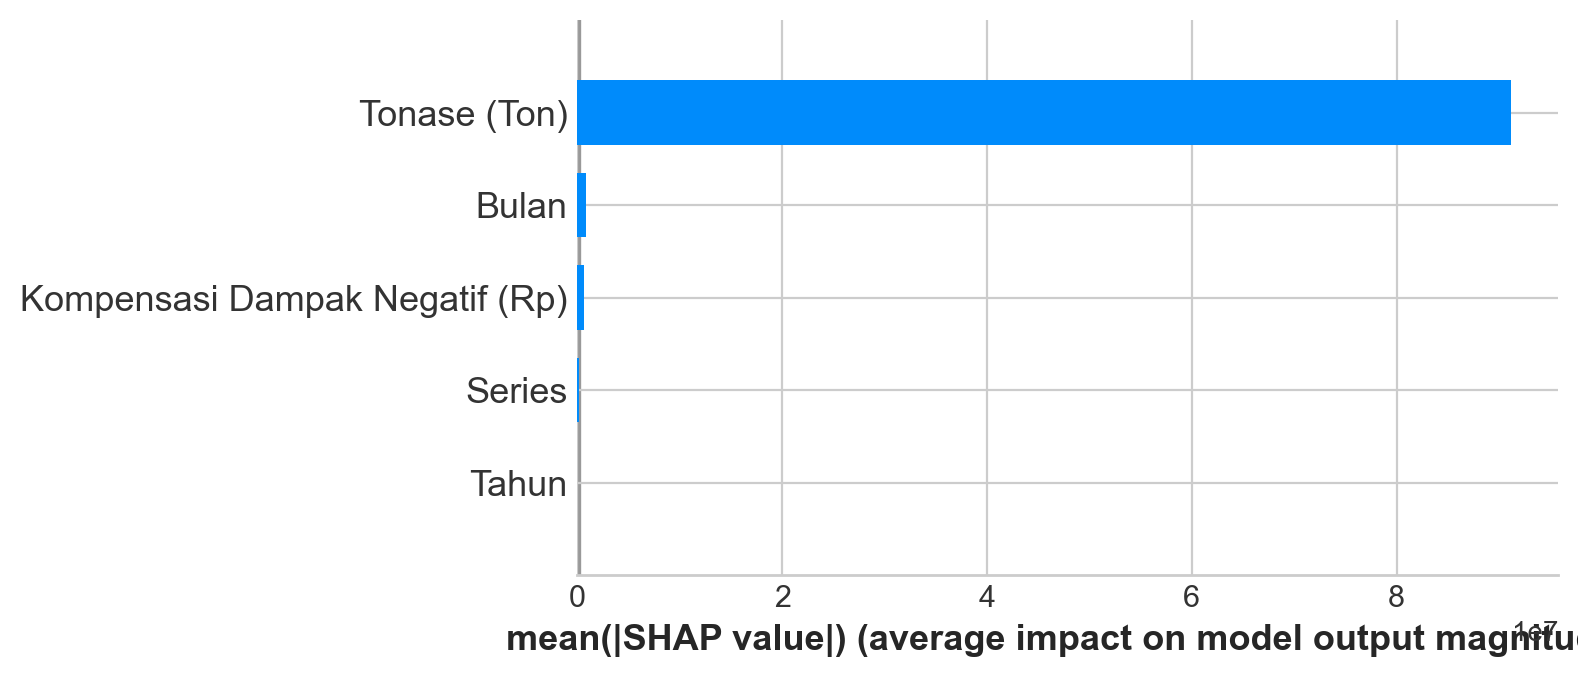

In [40]:
shap.summary_plot(shap_values, X_test, plot_type ="bar")

    Fitur penting yang memiliki nilai rata-rata SHAP terbesar pada metode Regresi Linier Berganda (MLR) pada variabel Kompensasi Jasa Pelayanan (Rp) adalah Tonase (Ton) Sampah yang didapatkan. Semakin tinggi Nilai pada variabel Tonase (Ton) memiliki kontribusi positif yang tinggi terhadap prediksi, sedangkan nilai yang rendah memiliki kontribusi negatif yang tinggi.

#### Export Dataset 
Untuk ditampilkan pada Streamlit

In [41]:
data_sampah.to_csv("dashboard/pages/data_sampah.csv")
Kompensasi_Jasa_pred.to_csv("dashboard/pages/kjp_with_mlr.csv")
Kompensasi_Jasa_pred_with_randomforest.to_csv("dashboard/pages/kjp_with_randomforest.csv")
Kompensasi_Jasa_pred_with_xgb.to_csv("dashboard/pages/kjp_with_xgb.csv")
data_eval_train.to_csv("dashboard/pages/data_eval_train.csv")
data_eval_test.to_csv("dashboard/pages/data_eval_test.csv")